#### References
1. https://www.hindawi.com/journals/complexity/2021/9985072/
2. https://www.stata.com/features/overview/bayesian-VAR-models/
3. https://ejournal.upi.edu/index.php/JEM/article/view/25742
4. https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html
5. https://barnesanalytics.com/bayesian-auto-regressive-time-series-analysis-pymc3/
6. https://github.com/ChadFulton/scipy2022-bayesian-time-series/blob/main/Poster.ipynb
7. https://github.com/xxl4tomxu98/vector-autoregressive-model-wage-inflations/blob/main/VAR-model.ipynb

# Modules

In [223]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import levene
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

# Data wrangling

In [33]:
# Input data
df = pd.read_csv("DATA/!Final.csv")
df.index = pd.to_datetime(df["Unnamed: 0"])
df=df.iloc[:,1:]
df.head()

,Tavg,RR,ff_avg,Sea level (cm)
Unnamed: 0,,,,
2023-01-01,25.9,38.0,2.0,176.153846
2023-01-02,27.2,134.4,3.0,171.076389
2023-01-03,26.7,0.7,2.0,167.580420
2023-01-04,27.0,3.2,2.0,170.379310
2023-01-05,27.5,31.3,3.0,176.531035


In [35]:
# Check for missing value
df.isna().sum()             # No missing value

Tavg              0
RR                0
ff_avg            0
Sea level (cm)    0
dtype: int64

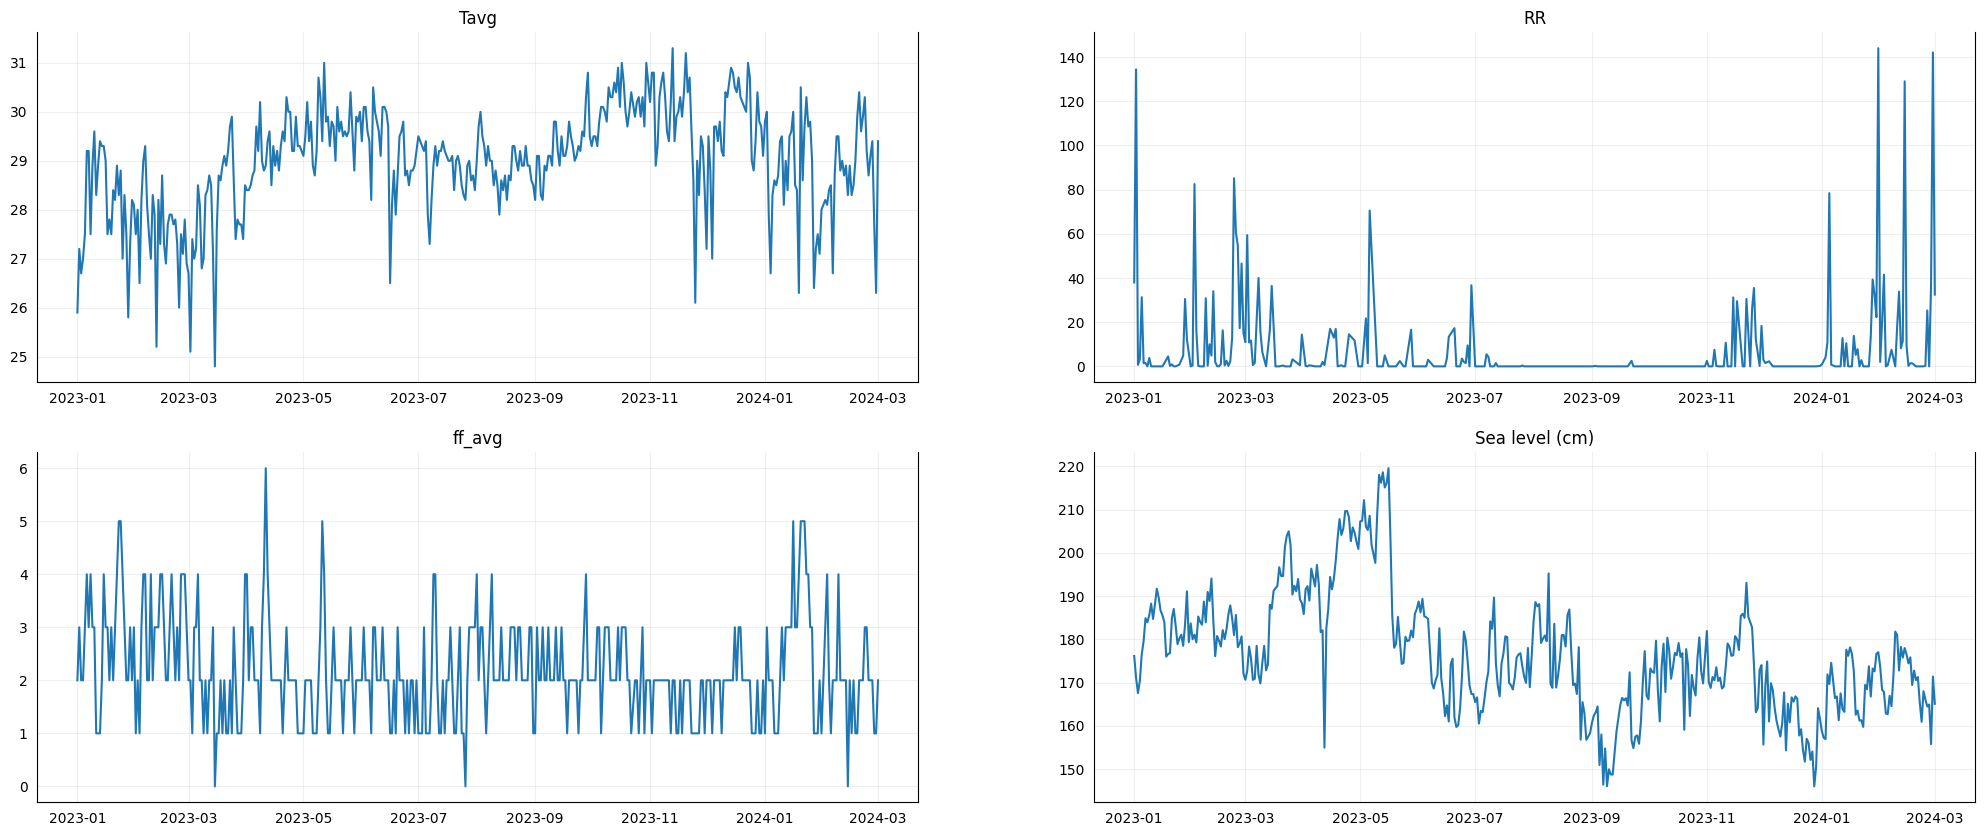

In [53]:
# Plot each columns
fig = plt.figure(figsize=(25,10))
for counter, colname in enumerate(df.columns):
    ax = fig.add_subplot(2, 2, counter+1)
    ax.plot(df[colname])
    ax.set_title(colname)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.grid("on", alpha=0.2)

Data telah dilakukan cleaning dengan baik, sehingga sudah tidak ada lagi amatan yang rusak

In [56]:
df.shape[0]

426

Decompose the the series to find the trend, seasonal and residual components

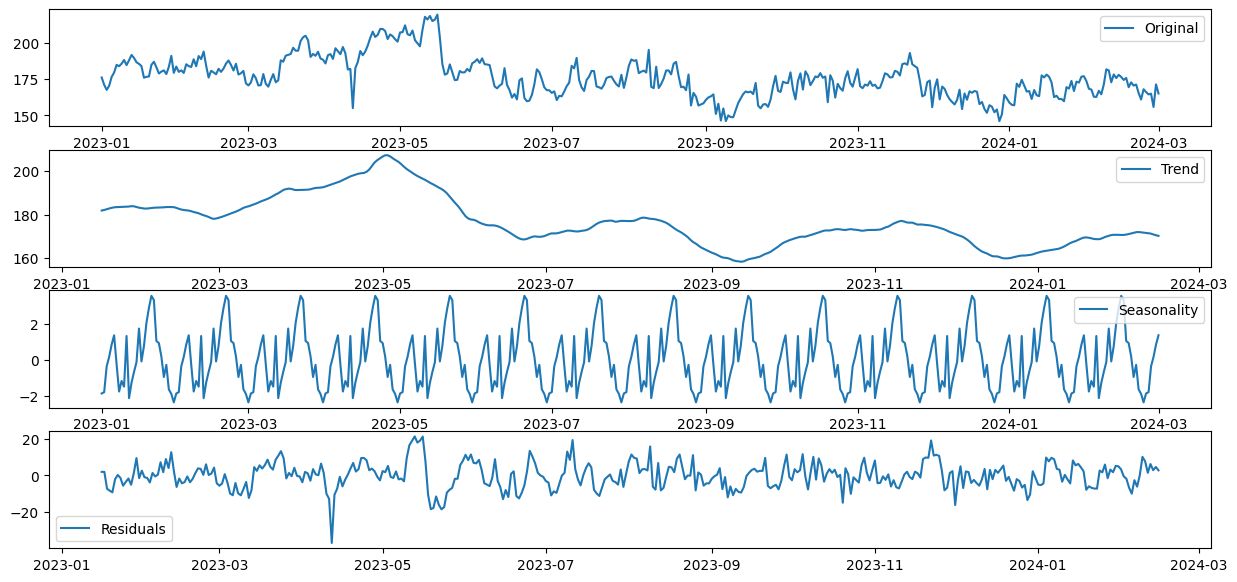

In [142]:
DecomposeResult = seasonal_decompose(df["Sea level (cm)"], period=30)
trend = DecomposeResult.trend
seasonal = DecomposeResult.seasonal
residual = DecomposeResult.resid

def plot_decomposition(original, trend, seasonal, residual):
    """
    Plot the components of a decomposition. Pass in the original univarate data which was decomposed, and then the 
    3 resulting components, being the trend, seasonal and residual parts. 
    """
    # Plot the results
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(4, 1, 1)
    ax.plot(original, label = 'Original')
    ax.legend(loc = 'best')
    ax = fig.add_subplot(4, 1, 2)
    ax.plot(trend, label = 'Trend')
    ax.legend(loc = 'best')
    ax = fig.add_subplot(4, 1, 3)
    ax.plot(seasonal, label = 'Seasonality')
    ax.legend(loc = 'best')
    ax = fig.add_subplot(4, 1, 4)
    ax.plot(residual, label = 'Residuals')
    ax.legend(loc = 'best')
    return

seasonality_plot = plot_decomposition(df["Sea level (cm)"], trend, seasonal, residual)

In [144]:
# Train evaluation test split

# Proposed split 70:20:10
train_data = df.iloc[:int(0.7*df.shape[0]),:]
eval_data = df.iloc[len(train_data):int(0.9*df.shape[0])]
test_data = df.iloc[int(0.9*df.shape[0]):,:]

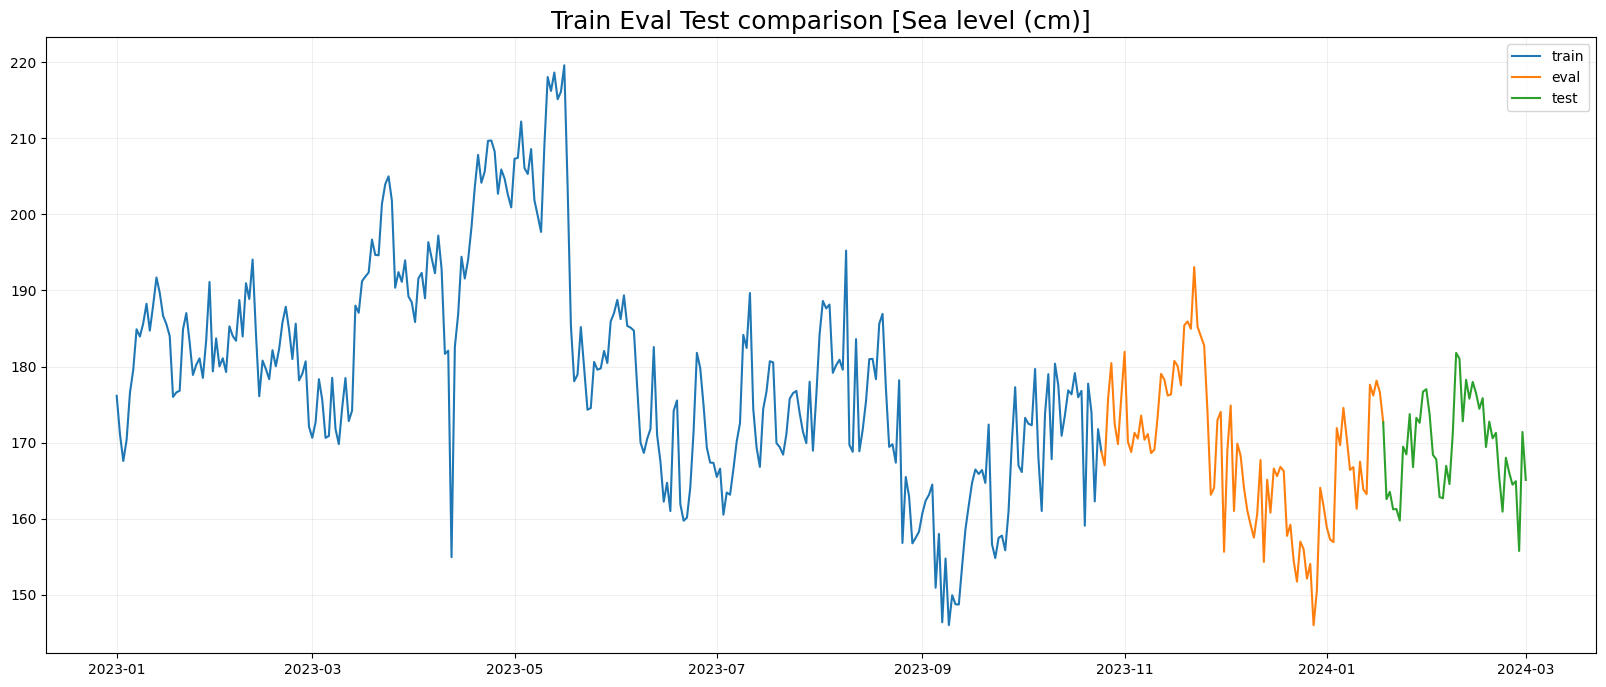

In [145]:
# Plot Train Eval split target only!

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,1,1)
ax.plot(train_data["Sea level (cm)"], label="train")
ax.plot(pd.concat((train_data["Sea level (cm)"].iloc[-1:],  eval_data["Sea level (cm)"])), label="eval")
ax.plot(pd.concat((eval_data["Sea level (cm)"].iloc[-1:],  test_data["Sea level (cm)"])), label="test")

ax.set_title("Train Eval Test comparison [Sea level (cm)]", fontsize = 18)
ax.grid("on", alpha=0.2)
ax.legend(loc="upper right")

## Stasionarity

### Mean

C:\Users\Rhey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


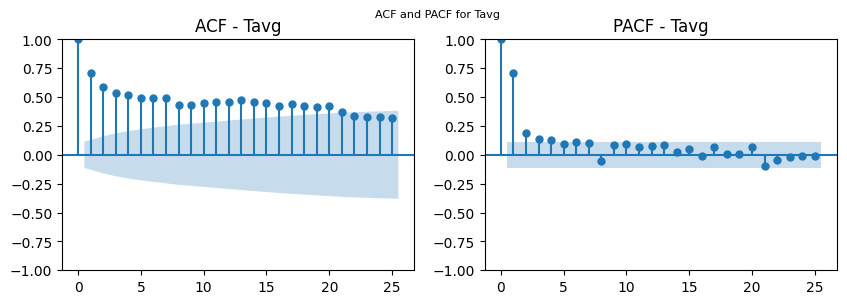

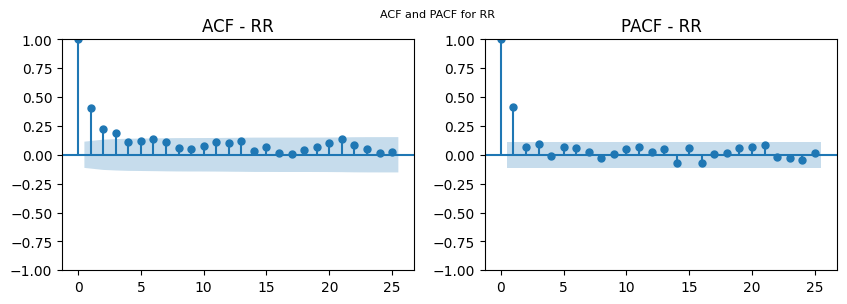

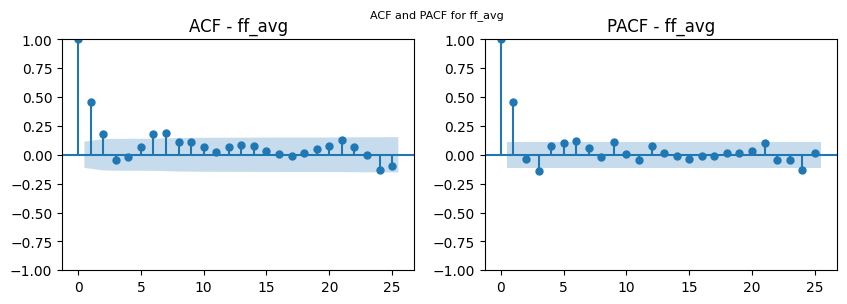

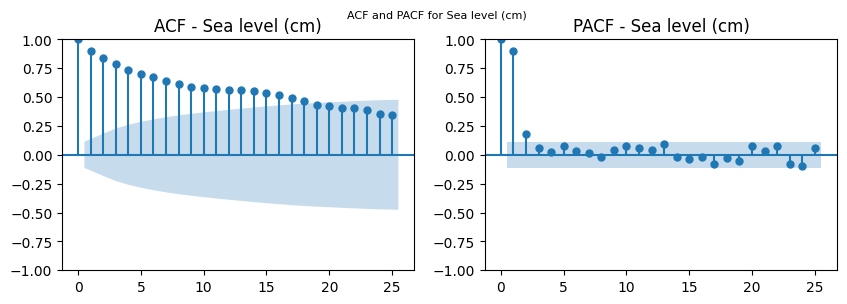

In [155]:
# ACf and PACF
# Plot ACF and PACF for each column
for column in train_data.columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    fig.suptitle(f'ACF and PACF for {column}', fontsize=8)
    
    # ACF plot
    plot_acf(train_data[column], ax=axes[0])
    axes[0].set_title(f'ACF - {column}')
    
    # PACF plot
    plot_pacf(train_data[column], ax=axes[1])
    axes[1].set_title(f'PACF - {column}')
    
    plt.show()

In [167]:
def adf_test(series, title='', signif=0.05):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    p_value=out[1]
    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
        return True
    print("")
    

non_stationary_columns=[]
for column in train_data.columns:
    if adf_test(train_data[column], title=column): non_stationary_columns.append(column)

Augmented Dickey-Fuller Test: Tavg
ADF Test Statistic              -1.067081
p-value                          0.728020
#Lags Used                      12.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
 => P-Value = 0.7280196933060263. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
Augmented Dickey-Fuller Test: RR
ADF Test Statistic            -1.109668e+01
p-value                        3.957855e-20
#Lags Used                     1.000000e+00
Number of Observations Used    2.960000e+02
Critical Value (1%)           -3.452637e+00
Critical Value (5%)           -2.871354e+00
Critical Value (10%)          -2.571999e+00
 => P-Value = 3.9578545898205783e-20. Rejecting Null Hypothesis.
 => Series is Stationary.

Augmented Dickey-Fuller Test: ff_avg
ADF Test Statistic              -5.208737
p-value                          0.000008
#Lags Us

Tavg Non stationary in mean

In [170]:
train_data_diff = train_data.copy()

for column in non_stationary_columns:
    train_data_diff[column] = train_data[column].diff().dropna()

# Drop the first row because differencing introduces NaN
train_data_diff = train_data_diff.dropna()

In [183]:
# Recheck
for column in train_data_diff.columns:
    print(f'{column}: ',end="")
    if adfuller(train_data_diff[column].dropna(), autolag='AIC')[1]<= 0.05: print('Stationary')
    else: print('Non-Stationary')

Tavg: Stationary
RR: Stationary
ff_avg: Stationary
Sea level (cm): Stationary


### Variance

In [190]:
def levene_test(series, num_segments=4):
    """
    Segments the time series into equal parts and applies Levene's test.
    
    Parameters:
    series: Time series data.
    num_segments: Number of segments to divide the data into.
    """
    segment_length = len(series) // num_segments
    segments = [series[i * segment_length:(i + 1) * segment_length] for i in range(num_segments)]
    
    return levene(*segments)

# Function to check stationarity in variance
def check_variance_stationarity(data):
    results = {}
    for column in data.columns:
        series = data[column].dropna()
        
        # ARCH Test
        arch_test_result = het_arch(series)
        arch_p_value = arch_test_result[1]
        is_arch_non_stationary = arch_p_value < 0.05
        
        # Levene's Test
        levene_test_result = levene_test(series)
        levene_p_value = levene_test_result.pvalue
        is_levene_non_stationary = levene_p_value < 0.05
        
        results[column] = {
            'ARCH Test p-value': arch_p_value,
            'Levene Test p-value': levene_p_value,
            'Non-Stationary in Variance (ARCH)': is_arch_non_stationary,
            'Non-Stationary in Variance (Levene)': is_levene_non_stationary
        }
        
    return results

# Check variance stationarity for each column in the dataset
variance_stationarity_results = check_variance_stationarity(train_data_diff)

# Print results
for column, result in variance_stationarity_results.items():
    print(f'Column: {column}')
    print(f'ARCH Test p-value: {result["ARCH Test p-value"]}')
    print(f'Non-Stationary in Variance (ARCH): {result["Non-Stationary in Variance (ARCH)"]}')
    print(f'Levene Test p-value: {result["Levene Test p-value"]}')
    print(f'Non-Stationary in Variance (Levene): {result["Non-Stationary in Variance (Levene)"]}')
    print('-' * 50)


Column: Tavg
ARCH Test p-value: 5.029394047333331e-08
Non-Stationary in Variance (ARCH): True
Levene Test p-value: 4.1579275763547817e-10
Non-Stationary in Variance (Levene): True
--------------------------------------------------
Column: RR
ARCH Test p-value: 4.6092373580580084e-05
Non-Stationary in Variance (ARCH): True
Levene Test p-value: 1.4080033236828708e-08
Non-Stationary in Variance (Levene): True
--------------------------------------------------
Column: ff_avg
ARCH Test p-value: 9.27953681906452e-13
Non-Stationary in Variance (ARCH): True
Levene Test p-value: 0.0020280112977887465
Non-Stationary in Variance (Levene): True
--------------------------------------------------
Column: Sea level (cm)
ARCH Test p-value: 5.4405462315622316e-45
Non-Stationary in Variance (ARCH): True
Levene Test p-value: 3.82054746951738e-07
Non-Stationary in Variance (Levene): True
--------------------------------------------------


Every column is Non stationary in variance

LOG Transformation!

In [218]:
def apply_log_transformation(data):
    data_log = data.copy()
    for column in data.columns:
        data_log[column] = np.log1p(data[column])
    return data_log

train_data_diff_log = apply_log_transformation(train_data_diff)

# Recheck
check_variance_stationarity(train_data_diff_log)

C:\Users\Rhey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


{'Tavg': {'ARCH Test p-value': 0.4576762537454536,
  'Levene Test p-value': 0.013922588593604443,
  'Non-Stationary in Variance (ARCH)': False,
  'Non-Stationary in Variance (Levene)': True},
 'RR': {'ARCH Test p-value': 7.54049550007396e-20,
  'Levene Test p-value': 1.392030991837379e-20,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True},
 'ff_avg': {'ARCH Test p-value': 3.657707397718049e-12,
  'Levene Test p-value': 0.00977163886418183,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True},
 'Sea level (cm)': {'ARCH Test p-value': 4.3995731678656926e-44,
  'Levene Test p-value': 3.3850980463013357e-06,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True}}

LOG Transform didn't sucessfully fix non stationary in variance problem, hence box cox transformation will be used

Boxcox requires data to have non negative value, data'll be shifted into positive value

In [219]:
min_value = train_data_diff_log.min().min()

# Add a constant to shift the data
shift_constant = 1 - min_value  # This ensures all values are positive

train_data_diff_log_shifted = train_data_diff_log + shift_constant

Boxcox transformation

In [222]:
def apply_boxcox_transformation(data):
    data_boxcox = data.copy()
    thelambda = {}
    for column in data.columns:
        data_boxcox[column], fitted_lambda = boxcox(data[column] + 1)  # Add 1 to avoid log(0)
        print(f'Lambda for {column}: {fitted_lambda}')
        thelambda[column] =fitted_lambda
    return data_boxcox


train_data_diff_log_shifted_boxcox = apply_boxcox_transformation(train_data_diff_log_shifted)
variance_stationarity_results_boxcox = check_variance_stationarity(train_data_diff_log_shifted_boxcox)
variance_stationarity_results_boxcox

Lambda for Tavg: 8.472135811722177
Lambda for RR: -5.04486620574816
Lambda for ff_avg: 2.868241728003235
Lambda for Sea level (cm): -4.511142493109299


{'Tavg': {'ARCH Test p-value': 0.15012463780911647,
  'Levene Test p-value': 2.3339019153016122e-05,
  'Non-Stationary in Variance (ARCH)': False,
  'Non-Stationary in Variance (Levene)': True},
 'RR': {'ARCH Test p-value': 6.694011379397993e-25,
  'Levene Test p-value': 1.4396068841529597e-18,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True},
 'ff_avg': {'ARCH Test p-value': 4.102734065606575e-12,
  'Levene Test p-value': 0.00598030268257377,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True},
 'Sea level (cm)': {'ARCH Test p-value': 1.1381129295614049e-43,
  'Levene Test p-value': 3.894119440989002e-06,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True}}

In [240]:
pt = PowerTransformer(method='yeo-johnson')

transformed_data = pt.fit_transform(train_data_diff_log)
transformed_data = pd.DataFrame(transformed_data, columns=train_data_diff_log.columns)

check_variance_stationarity(transformed_data)

{'Tavg': {'ARCH Test p-value': 0.02492855336153766,
  'Levene Test p-value': 0.000504319971857569,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True},
 'RR': {'ARCH Test p-value': 9.607002203418863e-18,
  'Levene Test p-value': 9.459772640767254e-17,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True},
 'ff_avg': {'ARCH Test p-value': 0.08768757122395666,
  'Levene Test p-value': 0.0061480334060498845,
  'Non-Stationary in Variance (ARCH)': False,
  'Non-Stationary in Variance (Levene)': True},
 'Sea level (cm)': {'ARCH Test p-value': 2.5061990074951326e-37,
  'Levene Test p-value': 3.878926549313241e-06,
  'Non-Stationary in Variance (ARCH)': True,
  'Non-Stationary in Variance (Levene)': True}}